In [1]:
# setup the matplotlib graphics library and configure it to show 
# figures inline in the notebook
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from numpy import linalg
from array import array
import matplotlib as mpl
from qutip import *

mpl.rcParams.update({'font.size': 16})

In [2]:
wc = 1.0  * 2 * np.pi  # cavity frequency
wa = 1.0  * 2 * np.pi  # atom frequency
g  = 0.05 * 2 * np.pi  # coupling strength
N = 4                  # number of cavity fock states
n_th_a = 0.0           # avg number of thermal bath excitation

tlist = np.linspace(0,25,101)

In [3]:
# intial state
psi0 = tensor(basis(N,0), basis(2,1))    # start with an excited atom

# operators
a  = tensor(destroy(N), qeye(2))
sm = tensor(qeye(N), destroy(2))

# Hamiltonian
Hrwa = wc * a.dag() * a + wa * sm.dag() * sm + g * (a.dag() * sm + a * sm.dag())
Horig = wc * a.dag() * a + wa * sm.dag() * sm + g * (a.dag() + a) * (sm + sm.dag())

#So, one of the big benefits of qutip is that you can just write the operators out like this,
#If you want the matrix, you just do Hrwa.full() or similar.

In [4]:
Hrwa

Quantum object: dims = [[4, 2], [4, 2]], shape = (8, 8), type = oper, isherm = True
Qobj data =
[[ 0.          0.          0.          0.          0.          0.
   0.          0.        ]
 [ 0.          6.28318531  0.31415927  0.          0.          0.
   0.          0.        ]
 [ 0.          0.31415927  6.28318531  0.          0.          0.
   0.          0.        ]
 [ 0.          0.          0.         12.56637061  0.44428829  0.
   0.          0.        ]
 [ 0.          0.          0.          0.44428829 12.56637061  0.
   0.          0.        ]
 [ 0.          0.          0.          0.          0.         18.84955592
   0.54413981  0.        ]
 [ 0.          0.          0.          0.          0.          0.54413981
  18.84955592  0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.         25.13274123]]

In [5]:
Horig

Quantum object: dims = [[4, 2], [4, 2]], shape = (8, 8), type = oper, isherm = True
Qobj data =
[[ 0.          0.          0.          0.31415927  0.          0.
   0.          0.        ]
 [ 0.          6.28318531  0.31415927  0.          0.          0.
   0.          0.        ]
 [ 0.          0.31415927  6.28318531  0.          0.          0.44428829
   0.          0.        ]
 [ 0.31415927  0.          0.         12.56637061  0.44428829  0.
   0.          0.        ]
 [ 0.          0.          0.          0.44428829 12.56637061  0.
   0.          0.54413981]
 [ 0.          0.          0.44428829  0.          0.         18.84955592
   0.54413981  0.        ]
 [ 0.          0.          0.          0.          0.          0.54413981
  18.84955592  0.        ]
 [ 0.          0.          0.          0.          0.54413981  0.
   0.         25.13274123]]

In [6]:
#Make sure that H is in the form of a Matrix
def evolve(psi,t,H):
    
    E,V=linalg.eigh(Horig.full())
    psit=0
    h=1 #to make things more simple
    
    for i in range(len(V)):
        v=np.array([V[i]])
        v=v.T
        cn=sum(psi*v)
        en=E[i]
        
        psit+=cn*np.exp(1j*t*en/h)*v
        
    return psit
        
    

In [7]:
psiinit=psi0.full()
psiinit

array([[0.+0.j],
       [1.+0.j],
       [0.+0.j],
       [0.+0.j],
       [0.+0.j],
       [0.+0.j],
       [0.+0.j],
       [0.+0.j]])

In [8]:
evolve(psiinit,1,Horig.full())

array([[-3.83333748e-19+1.35298452e-19j],
       [ 9.51061024e-01-2.49188662e-04j],
       [ 2.36973785e-03+3.08308624e-01j],
       [-3.76462400e-18+1.98051160e-17j],
       [-8.69532775e-18+1.74549476e-17j],
       [ 1.70249264e-03+1.42031491e-02j],
       [ 1.57563893e-03+1.46946521e-02j],
       [ 3.33738677e-17+2.45852137e-17j]])

Ok, so now that we can time evolve stuff, Rabi oscillations are given by expectation values of a.dag() * a and sm.dag() * sm, so need to get those not as Qobj too. They are just given by (a.dag() * a).full()

In [9]:
A1=(a.dag()*a).full()
A2=(sm.dag()*sm).full()

Now, expectation values calculated as normal with vectors.

# Rabi Oscillations

Text(0.5, 1.0, 'Vacuum Rabi Oscillations')

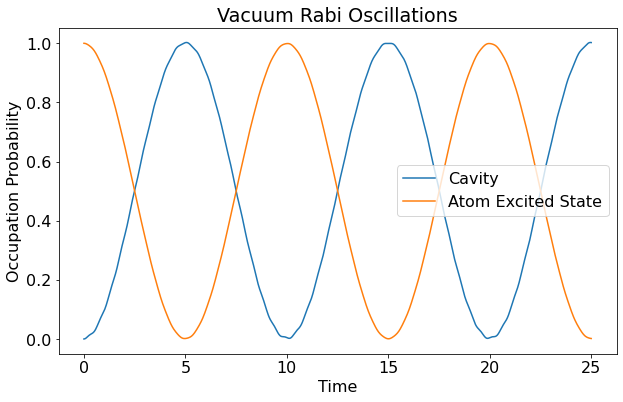

In [10]:
A1v=[]
A2v=[]

tlist = np.linspace(0,25,1000)

for t in tlist:
    psi=evolve(psiinit,t,Horig.full())
    psiT=np.conj(psi).T
    
    xA1 = np.dot(psiT,np.dot(A1,psi))
    xA2 = np.dot(psiT,np.dot(A2,psi))
    
    A1v.append(xA1[0])
    A2v.append(xA2[0])
    
    
fig, axes = plt.subplots(1, 1, figsize=(10,6))

axes.plot(tlist, np.real(A1v), label="Cavity")
axes.plot(tlist, np.real(A2v), label="Atom Excited State")
axes.legend()
axes.set_xlabel('Time')
axes.set_ylabel('Occupation Probability')
axes.set_title('Vacuum Rabi Oscillations')

Now, want to verify that we get a similar result with the Rotating Wave Approximation.

Text(0.5, 1.0, 'Vacuum Rabi Oscillations (RWA)')

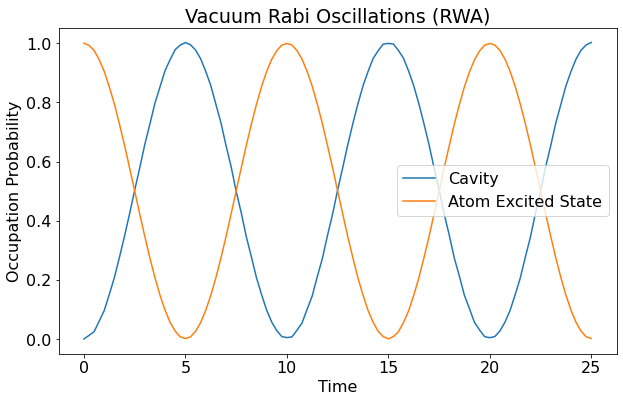

In [11]:
A1v=[]
A2v=[]

tlist = np.linspace(0,25,101)

for t in tlist:
    psi=evolve(psiinit,t,Hrwa.full())
    psiT=np.conj(psi).T
    
    xA1 = np.dot(psiT,np.dot(A1,psi))
    xA2 = np.dot(psiT,np.dot(A2,psi))
    
    A1v.append(xA1[0])
    A2v.append(xA2[0])
    
    
fig, axes = plt.subplots(1, 1, figsize=(10,6))

axes.plot(tlist, np.real(A1v), label="Cavity")
axes.plot(tlist, np.real(A2v), label="Atom Excited State")
axes.legend()
axes.set_xlabel('Time')
axes.set_ylabel('Occupation Probability')
axes.set_title('Vacuum Rabi Oscillations (RWA)')

So, we get very similar results. However we can look at how well the rotating wave works for different energy levels as we change the coupling strength or the cavity wavelength.

# Energy Level Comparison for Original vs RWA

In [12]:
N = 4       #number of cavity fock states
wc = 1  # cavity frequency
wa = 1
gvec=np.linspace(0,1,50)

# intial state
psi0 = tensor(basis(N,0), basis(2,1))    # start with an excited atom

# operators
a  = tensor(destroy(N), qeye(2))
sm = tensor(qeye(N), destroy(2))

origlvls=[]
rwalvls=[]
for g in gvec:
    
    Hrwa = wc * a.dag() * a + wa * sm.dag() * sm + g * (a.dag() * sm + a * sm.dag())
    Horig = wc * a.dag() * a + wa * sm.dag() * sm + g * (a.dag() + a) * (sm + sm.dag())
    
    evo,eko=Horig.eigenstates()
    evr,ekr=Hrwa.eigenstates()
    origlvls.append(evo)
    rwalvls.append(evr)

    
    
n1=len(origlvls)
n2=len(origlvls[1])
elvls=np.zeros([n1,n2])
erlvls=np.zeros([n1,n2])
for i in range(n1):
    for j in range(len(origlvls[1])):
        elvls[i,j]=origlvls[i][j]
        erlvls[i,j]=rwalvls[i][j]

## Energy Levels as a Function of $g$

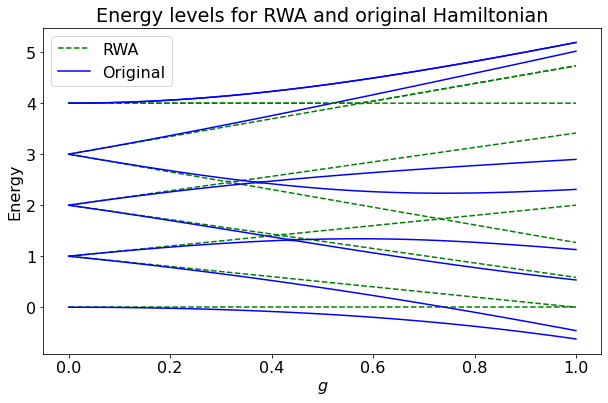

In [13]:
fig, axes = plt.subplots(1, 1, figsize=(10,6))

for i in range(n2):
    axes.plot(gvec,erlvls[:,i],"g--")
    axes.plot(gvec,elvls[:,i],"b-")

axes.plot(gvec,erlvls[:,n2-1],"g--",label="RWA")
axes.plot(gvec,elvls[:,n2-1],"b-",label="Original")
axes.legend()
axes.set_xlabel('$g$')
axes.set_ylabel('Energy')
axes.set_title('Energy levels for RWA and original Hamiltonian')

plt.show()

## Energy Levels as a Function of $\omega_c$

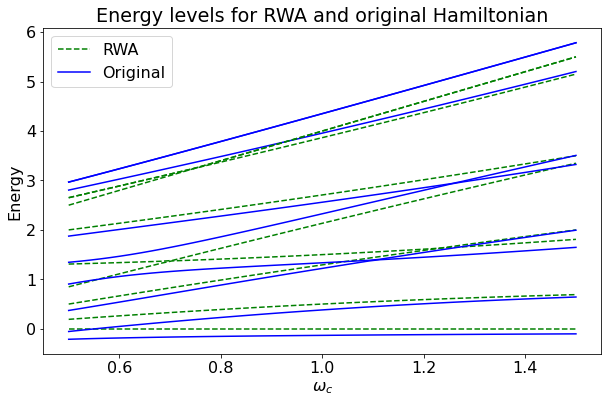

In [14]:
N = 4       #number of cavity fock states
wa = 1
g=0.5

wvec=np.linspace(0.5,1.5,50)

origlvls=[]
rwalvls=[]
for wc in wvec:
    
    Hrwa = wc * a.dag() * a + wa * sm.dag() * sm + g * (a.dag() * sm + a * sm.dag())
    Horig = wc * a.dag() * a + wa * sm.dag() * sm + g * (a.dag() + a) * (sm + sm.dag())
    
    evo,eko=Horig.eigenstates()
    evr,ekr=Hrwa.eigenstates()
    origlvls.append(evo)
    rwalvls.append(evr)

n1=len(origlvls)
n2=len(origlvls[1])
eolvls=np.zeros([n1,n2])
erlvls=np.zeros([n1,n2])

for i in range(n1):
    for j in range(len(rwalvls[1])):
        erlvls[i,j]=rwalvls[i][j]
        eolvls[i,j]=origlvls[i][j]



    
fig, axes = plt.subplots(1, 1, figsize=(10,6))

for i in range(n2):
    axes.plot(wvec,erlvls[:,i],"g--")
    axes.plot(wvec,eolvls[:,i],"b-")

axes.plot(wvec,erlvls[:,n2-1],"g--",label="RWA")
axes.plot(wvec,eolvls[:,n2-1],"b-",label="Original")
axes.legend()
axes.set_xlabel('$\omega_c$')
axes.set_ylabel('Energy')
axes.set_title('Energy levels for RWA and original Hamiltonian')

plt.show()

# As Before, with N=15

Here, we are going to keep only the first 10 energy levels for clarity.

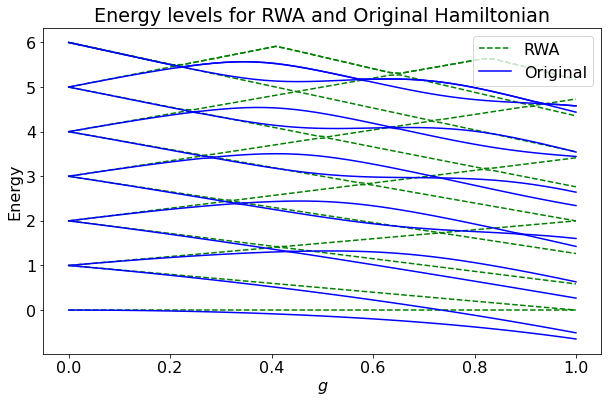

In [15]:
N = 15       #number of cavity fock states
wc = 1  # cavity frequency
wa = 1
gvec=np.linspace(0,1,50)

# intial state
psi0 = tensor(basis(N,0), basis(2,1))    # start with an excited atom

# operators
a  = tensor(destroy(N), qeye(2))
sm = tensor(qeye(N), destroy(2))

origlvls=[]
rwalvls=[]
for g in gvec:
    
    Hrwa = wc * a.dag() * a + wa * sm.dag() * sm + g * (a.dag() * sm + a * sm.dag())
    Horig = wc * a.dag() * a + wa * sm.dag() * sm + g * (a.dag() + a) * (sm + sm.dag())
    
    evo,eko=Horig.eigenstates()
    evr,ekr=Hrwa.eigenstates()
    origlvls.append(evo)
    rwalvls.append(evr)

    
    
n1=len(origlvls)
n2=len(origlvls[1])
elvls=np.zeros([n1,n2])
erlvls=np.zeros([n1,n2])
for i in range(n1):
    for j in range(len(origlvls[1])):
        elvls[i,j]=origlvls[i][j]
        erlvls[i,j]=rwalvls[i][j]
        
        
fig, axes = plt.subplots(1, 1, figsize=(10,6))

for i in range(12):
    axes.plot(gvec,erlvls[:,i],"g--")
    axes.plot(gvec,elvls[:,i],"b-")

axes.plot(gvec,erlvls[:,12-1],"g--",label="RWA")
axes.plot(gvec,elvls[:,12-1],"b-",label="Original")
axes.legend()
axes.set_xlabel('$g$')
axes.set_ylabel('Energy')
axes.set_title('Energy levels for RWA and Original Hamiltonian')

plt.show()

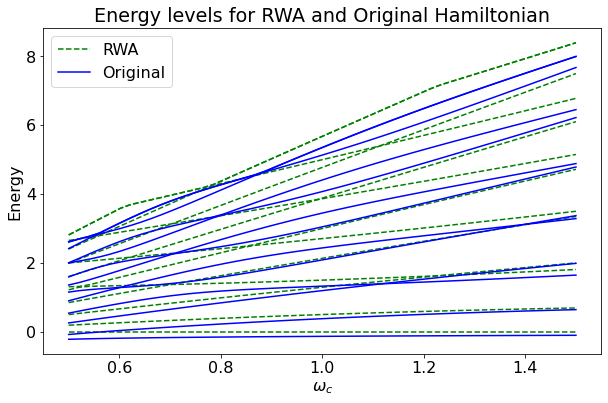

In [16]:
N = 15       #number of cavity fock states
wa = 1
g=0.5

wvec=np.linspace(0.5,1.5,50)

origlvls=[]
rwalvls=[]
for wc in wvec:
    
    Hrwa = wc * a.dag() * a + wa * sm.dag() * sm + g * (a.dag() * sm + a * sm.dag())
    Horig = wc * a.dag() * a + wa * sm.dag() * sm + g * (a.dag() + a) * (sm + sm.dag())
    
    evo,eko=Horig.eigenstates()
    evr,ekr=Hrwa.eigenstates()
    origlvls.append(evo)
    rwalvls.append(evr)

n1=len(origlvls)
n2=len(origlvls[1])
eolvls=np.zeros([n1,n2])
erlvls=np.zeros([n1,n2])

for i in range(n1):
    for j in range(len(rwalvls[1])):
        erlvls[i,j]=rwalvls[i][j]
        eolvls[i,j]=origlvls[i][j]



    
fig, axes = plt.subplots(1, 1, figsize=(10,6))

for i in range(12):
    axes.plot(wvec,erlvls[:,i],"g--")
    axes.plot(wvec,eolvls[:,i],"b-")

axes.plot(wvec,erlvls[:,12-1],"g--",label="RWA")
axes.plot(wvec,eolvls[:,12-1],"b-",label="Original")
axes.legend()
axes.set_xlabel('$\omega_c$')
axes.set_ylabel('Energy')
axes.set_title('Energy levels for RWA and Original Hamiltonian')

plt.show()